In [1]:
import pandas as pd, numpy as np

np.random.seed(42)
n = 250

df = pd.DataFrame({
    "customer_id": range(1001, 1001+n),
    "usage_gb": np.random.gamma(5, 2, n).round(2),
    "call_mins": np.random.normal(350, 120, n).clip(50,900).round(0),
    "complaints": np.random.poisson(0.6, n),
    "plan_type": np.random.choice(["Prepaid","Postpaid"], n, p=[0.6,0.4]),
    "region": np.random.choice(["Delhi","Mumbai","Chennai","Kolkata"], n)
})

# Bill generation
base = 99 + 8*df["usage_gb"] + 0.2*df["call_mins"] + 30*df["complaints"]
base += np.where(df["plan_type"]=="Postpaid", 120, 0)
df["monthly_bill"] = (base + np.random.normal(0, 40, n)).round(2)

# Churn probability
logit = -2.2 + 0.35*df["complaints"] - 0.002*(df["monthly_bill"]-200) + \
        0.15*(df["usage_gb"]<5)
prob = 1/(1+np.exp(-logit))
df["churn"] = np.where(np.random.rand(n)<prob, "Yes", "No")

df.to_csv("billing_churn.csv", index=False)
print("Saved billing_churn.csv with shape:", df.shape)
df.head()


Saved billing_churn.csv with shape: (250, 8)


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No


In [2]:
import pandas as pd

df = pd.read_csv("billing_churn.csv")
print(df.shape)
df.head()


(250, 8)


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No


In [4]:
import numpy as np

num_features = ["usage_gb","call_mins","complaints"]
X_num = df[num_features].copy()

# Targets
y_reg = df["monthly_bill"]
y_clf = (df["churn"]=="Yes").astype(int)




In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_num, y_reg, test_size=0.3, random_state=42)

_, _, y_clf_train, y_clf_test = train_test_split(
    X_num, y_clf, test_size=0.3, random_state=42)


=== REGRESSION ===
Features: ['usage_gb', 'call_mins', 'complaints']
Coefficients: {'usage_gb': 6.805, 'call_mins': 0.226, 'complaints': 34.865}
Intercept: 150.35
RMSE: 71.07


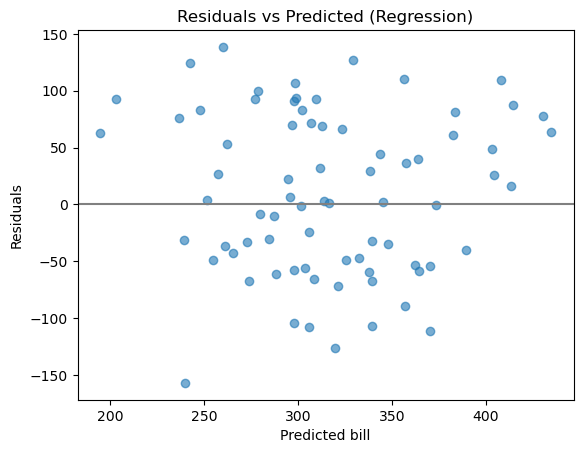


Saved file: billing_churn_with_predictions.csv


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn,predicted_monthly_bill
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No,396.07
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No,326.31
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No,295.10
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No,305.08
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No,380.54


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

reg = LinearRegression().fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))

print("=== REGRESSION ===")
print("Features:", num_features)
print("Coefficients:", dict(zip(num_features, reg.coef_.round(3))))
print("Intercept:", round(reg.intercept_, 2))
print("RMSE:", round(rmse, 2))

# Residual plot
resid = y_reg_test - y_reg_pred
plt.scatter(y_reg_pred, resid, alpha=0.6)
plt.axhline(0, color='gray')
plt.xlabel("Predicted bill")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Regression)")
plt.show()

# Add predictions to dataset
df = pd.read_csv("billing_churn.csv")
X_all = df[num_features]
df["predicted_monthly_bill"] = reg.predict(X_all).round(2)

output_path = "billing_churn_with_predictions.csv"
df.to_csv(output_path, index=False)
print("\nSaved file:", output_path)
df.head()


In [7]:
threshold = 0.5


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

clf = LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")
clf.fit(X_train, y_clf_train)

# Predictions
y_clf_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_clf_test, y_clf_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_clf_test, y_clf_pred, average="binary", zero_division=0
)

print("\n=== CLASSIFICATION ===")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1 Score: {f1:.3f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_clf_test, y_clf_pred))

print("\nDetailed Report:\n",
      classification_report(y_clf_test, y_clf_pred,
                            target_names=["No churn","Churn"],
                            zero_division=0))



=== CLASSIFICATION ===
Accuracy: 0.547
Precision: 0.114
Recall: 0.571
F1 Score: 0.190

Confusion Matrix:
 [[37 31]
 [ 3  4]]

Detailed Report:
               precision    recall  f1-score   support

    No churn       0.93      0.54      0.69        68
       Churn       0.11      0.57      0.19         7

    accuracy                           0.55        75
   macro avg       0.52      0.56      0.44        75
weighted avg       0.85      0.55      0.64        75



In [9]:
df = pd.read_csv("billing_churn_with_predictions.csv")

X_all = df[num_features]
df["churn_probability"] = clf.predict_proba(X_all)[:, 1].round(3)
df["predicted_churn"] = (df["churn_probability"] >= threshold).astype(int)

output_file = "billing_churn_with_predictions_churn.csv"
df.to_csv(output_file, index=False)

print("\nSaved file:", output_file)
df.head()



Saved file: billing_churn_with_predictions_churn.csv


,customer_id,usage_gb,call_mins,complaints,plan_type,region,monthly_bill,churn,predicted_monthly_bill,churn_probability,predicted_churn
0,1001,11.65,427.0,2,Prepaid,Chennai,337.36,No,396.07,0.512,1
1,1002,8.75,514.0,0,Prepaid,Kolkata,305.34,No,326.31,0.288,0
2,1003,8.36,234.0,1,Prepaid,Mumbai,245.95,No,295.10,0.621,1
3,1004,8.36,432.0,0,Prepaid,Chennai,248.32,No,305.08,0.354,0
4,1005,17.95,477.0,0,Prepaid,Delhi,374.76,No,380.54,0.221,0


In [10]:
print("\nSUMMARY")
print(f"Regression RMSE: {rmse:.2f}")
print(f"Classification → Acc: {acc:.3f}  Prec: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")



SUMMARY
Regression RMSE: 71.07
Classification → Acc: 0.547  Prec: 0.114  Recall: 0.571  F1: 0.190
